In [36]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

import os
from os.path import splitext, split
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../fibermetric/')
from fibermetric import utils, histology

import nibabel as nib
import matplotlib.pyplot as plt
from fury import actor, window
from IPython.core.display import Image
from PIL import Image as PILImage
import numpy as np
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere
from dipy.core.gradients import gradient_table
import time

from scipy.ndimage import gaussian_filter

# # from cloudvolume import CloudVolume

# # vol = CloudVolume(
# #     "s3://open-neurodata/kutten/Control189/Grayscale", mip=0, use_https=True
# # )

# # # load data into numpy array
# # cutout = vol[10752:11264, 13312:13824, 704:720]

# # # save cutout as TIFF
# # tifffile.imwrite("data.tiff", data=np.transpose(cutout))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# define some useful functions

In [12]:
def polar_to_xyz(theta, phi, r=1):
    z = r * np.cos(theta)
    xy_hyp = r * np.sin(theta)
    y = xy_hyp * np.sin(phi)
    x = xy_hyp * np.cos(phi)
    
    return x, y, z


# helper functions for visualization
WINDOW_SIZE = (400, 400)
SAVEIM_FOLDER = 'images'
if not os.path.exists(SAVEIM_FOLDER):
    os.mkdir(SAVEIM_FOLDER)

def screenshot_animated_sf(sf, sphere, rot=True, norm=True, scale=True, title='Modeling', theta_step=30):
    '''
    Render a spherical function to file. Returns path to image.
    '''
    
    scene = window.Scene()
    scene.background(window.colors.white)
    
    sf_actor = actor.odf_slicer(sf[None, None, None, :],
                               sphere=sphere, colormap='jet',
                               norm=norm)#, radial_scale=scale)
    if rot:
        sf_actor.RotateX(90)
    scene.add(sf_actor)
    
    images = []
    n_frames = 360//theta_step
    for i in np.arange(n_frames):
#         sf_actor.RotateX(theta_step)
#         sf_actor.RotateY(theta_step)
        sf_actor.RotateZ(theta_step)

        scene.reset_clipping_range()
        images.append(PILImage.fromarray(window.snapshot(scene, size=WINDOW_SIZE)))
        
    frame_duration = 15000 // theta_step
    filename = os.path.join(SAVEIM_FOLDER, '{0}.gif'.format(title))
    images[0].save(filename, save_all=True, append_images=images[1:],
                  duration=frame_duration, optimize=False, loop=0)
    scene.clear()

    return filename
    
def screenshot_gradients(sph_gtab, title='Modeling'):
    scene = window.Scene()
    scene.background(window.colors.white)

    scene.add(actor.point(sph_gtab.vertices, window.colors.green, point_radius=0.05))

    outfile = os.path.join(SAVEIM_FOLDER, '{0}.png'.format(title))
    window.snapshot(scene, size=WINDOW_SIZE, fname=outfile)

    scene.clear()
    return outfile


# Set up example measurement

In [13]:
rng = np.random.default_rng(1)

mu = 0
kappa = 5
size = 2**10

theta = rng.vonmises(mu, kappa, size=size)/2 + np.pi/2
theta_flip = np.pi - theta
theta = np.concatenate((theta, theta_flip))
phi = rng.vonmises(mu, kappa=0, size=size)
phi_flip = np.where(phi < 0, phi + np.pi, phi - np.pi)
phi = np.concatenate((phi, phi_flip))

polar = np.stack((theta,phi), -1)
print(f'polar shape: {polar.shape}')

polar shape: (2048, 2)


In [14]:
xyz = np.array(polar_to_xyz(polar[...,0], polar[...,1])).transpose()
print(f'xyz shape: {xyz.shape}')

xyz shape: (2048, 3)


# Set up histogram bin points

iterations: 35
time: 0.04903268814086914
delta: 0.08628716724342667
potential: 14790.730781348626


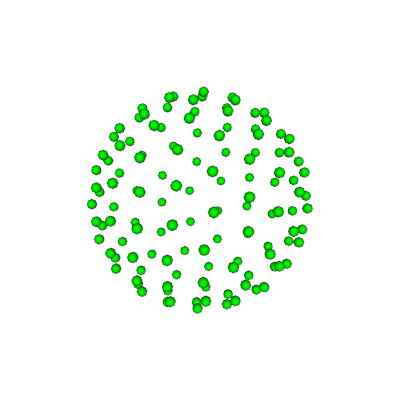

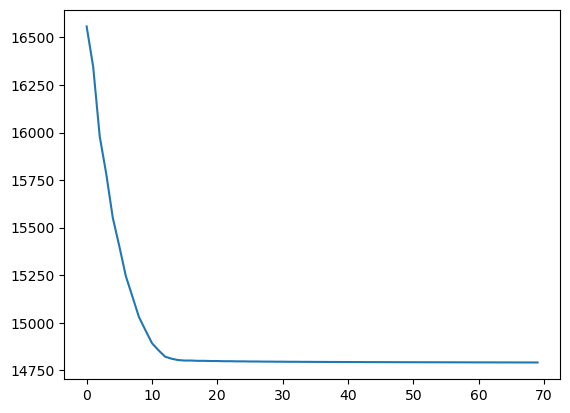

In [15]:
n_pts = 64
bvalue = 1000
np.random.seed(0)
theta = np.pi*np.random.rand(n_pts)
phi = 2 * np.pi*np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)

it = 1
start = time.time()
hsph_updated, potential = disperse_charges(hsph_initial,2)#, const=0.5)
while np.abs(potential[-2]-potential[-1]) > 0.1:
    hsph_updated, pot = disperse_charges(hsph_updated,2)#, const=0.5)
    potential = np.append(potential,pot)
    it += 1
stop = time.time()
print(f"iterations: {it}")
print(f"time: {stop-start}")
print(f"delta: {np.abs(potential[-2]-potential[-1])}")
print(f"potential: {potential[-1]}")

plt.figure()
plt.plot(potential)

vertices = hsph_updated.vertices
values = np.ones(vertices.shape[0])
bvecs = np.vstack((vertices))
bvals = np.hstack((bvalue * values))
# add some b=0 bvals/bvecs
bvecs = np.insert(bvecs, (0,bvecs.shape[0]), np.array([0,0,0]), axis = 0)
bvals = np.insert(bvals, (0, bvals.shape[0]), 0)

gtab = gradient_table(bvals, bvecs)
sph_gtab = Sphere(xyz=np.vstack((vertices,-vertices)))

image = screenshot_gradients(sph_gtab, title='Example directions')
Image(filename=image)

In [16]:
# fill in histogram
bins = sph_gtab.vertices
hist = np.zeros(len(bins))
start = time.time()
for v in xyz: # find angles between one vector and every vertex 
    dist = np.arccos(np.dot(vertices,v))
    v_idx = np.argmax(np.abs(np.pi/2 - dist)) # find the vertex closest to the vector or the vector +- pi
    hist[v_idx] += 1
    hist[v_idx+len(vertices)] += 1
stop = time.time()
print(f'time elapsed: {stop-start}')

time elapsed: 0.0159914493560791


In [17]:
I.shape

(1024, 1024, 53)

In [18]:
I = np.zeros((256,len(xyz),3))
I[:] = xyz

In [19]:
bins = sph_gtab.vertices
signal = np.zeros((len(I), len(bins)))
start = time.time()
for v in I[:]:
    dist = np.arccos(np.dot(vertices,v.T))
    v_idx = np.argmax(np.abs(np.pi/2 - dist), axis=0)
    signal[:,v_idx] += 1
    signal[:,v_idx+len(vertices)] += 1
stop = time.time()
print(f'time elapsed: {stop-start}')

time elapsed: 1.7815463542938232


In [20]:
signal.shape

(256, 128)

<BarContainer object of 128 artists>

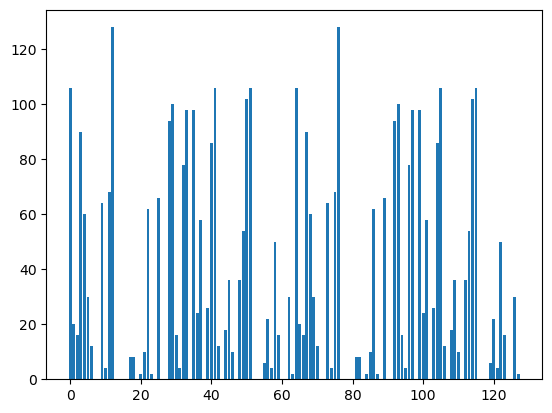

In [21]:
plt.figure()
plt.bar(np.arange(len(hist)),hist)

In [22]:
from dipy.reconst.shm import sh_to_sf_matrix, sh_to_sf
from dipy.data import get_sphere

print('Building SH matrix of order 8')
B, invB = sh_to_sf_matrix(sph_gtab, 8)
print('Shape,', B.shape, '\n')

print('Building high resolution SH matrix of order 8')
sphere = get_sphere('symmetric724')
sphere = sphere.subdivide(2)
B_highres, invB_highres = sh_to_sf_matrix(sphere, 8)
print('Shape: ', B_highres.shape)

Building SH matrix of order 8
Shape, (45, 128) 

Building high resolution SH matrix of order 8
Shape:  (45, 11554)


In [23]:
sh_signal = sh_signal.reshape(16,16,45)

NameError: name 'sh_signal' is not defined

In [ ]:
print('Estimate SH coefficients of the signal')
# S = B*sh_signal => sh_signal = invB * S
# sh_signal = np.dot(invB.T, hist)
sh_signal = np.dot(signal, invB)
print('SH signal shape, ', sh_signal.shape, '\n')
# print('Project back SH coefficient to the high resolution sphere')
# signal_sphere = np.dot(sh_signal, B_highres)
# # signal_sphere = np.dot(sh_signal.T, B_highres)
# print('SF signal shape: ', signal_sphere.shape)

In [ ]:
image = screenshot_animated_sf(signal_sphere, sphere, title='multi-tensor odf signal', theta_step=360, rot=False)

Image(filename=image)

# 3D structure tensors from optically cleared spinal cords

In [47]:
root = '/home/brysongray/shattuck/RodentToolsData/OpticallyClearedSpinalCords/nii2/EAE32_F1LC_Sp10x/'
s0_path = 'TileScan_001_s0.nii.gz'
# root = '/home/brysongray/data/spinal_cords/'
# s0_path = 'TileScan_001_s0.subvol.nii.gz'

s0_nii = nib.load(os.path.join(root,s0_path))
affine = s0_nii.affine
header = s0_nii.header
print(affine)
print(header)

[[ 0.89099997  0.          0.          0.        ]
 [ 0.          0.89099997  0.          0.        ]
 [ 0.          0.         11.02000046  0.        ]
 [ 0.          0.          0.          1.        ]]
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [   3 1024 1024   53    1    0    0    0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [ 1.     0.891  0.891 11.02   1.     1.     1.     1.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 255
glmin           : 0
descrip         : b''
aux_file    

In [49]:
out = '/home/brysongray/data/spinal_cords/testing/'

patch = s0_nii.get_fdata()#[789:989,789:989,6:16]
eig_header = s0_nii.header
img_header = s0_nii.header
# dim = np.array([3, 200, 200, 10, 1, 0, 0, 0], dtype='int16')
# img_header['dim'] = dim
# eig_header['dim'] = dim
eig_header['datatype'] = 16
eig_header['bitpix'] = 32
print(f"header: {eig_header}")
print(f"affine: {affine}")

# img_patch = nib.Nifti1Image(patch, affine=affine, header=img_header)
# nib.save(img_patch,os.path.join(out,'TileScan_001_s0_patch.nii.gz'))

header: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [   3 1024 1024   53    1    0    0    0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [ 1.     0.891  0.891 11.02   1.     1.     1.     1.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 255
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0


In [50]:
# out = '/home/brysongray/data/spinal_cords/structure_tensors/'
out = '/home/brysongray/data/spinal_cords/testing/'
file = s0_path
I = patch
thresh = 20
# mask = np.where(patch > 20, 1, 0)
sigma1 = 1
sigma2 = 1.5
dI = (0.891,0.891,11.02)
S = histology.structure_tensor(I, derivative_sigma=sigma1,tensor_sigma=sigma2, dI=dI)
w,v = np.linalg.eigh(S)
w_inv = (1/w)
w_inv_norm = w_inv / np.max(w_inv, axis=-1, keepdims=True)
w_inv_norm = w_inv_norm.astype('float32')
# w_inv_norm = w_inv_norm * mask[...,None]
w_inv = w_inv.astype('float32')
w = w.astype('float32')
v = v.astype('float32')
S_eig = {"v0_z":v[...,0,0], "v1_z":v[...,0,1], "v2_z":v[...,0,2], "v0_y":v[...,1,0], "v1_y":v[...,1,1], "v2_y":v[...,1,2],
        "v0_x":v[...,2,0], "v1_x":v[...,2,1], "v2_x":v[...,2,2], "w0":w[...,0], "w1":w[...,1], "w2":w[...,2],
        "w0_inv":w_inv[...,0], "w1_inv":w_inv[...,1], "w2_inv":w_inv[...,2],
        "w0_inv_norm":w_inv_norm[...,0], "w1_inv_norm":w_inv_norm[...,1], "w2_inv_norm":w_inv_norm[...,2]}
for label,vol in S_eig.items():
    img = nib.Nifti1Image(vol, affine, eig_header)
    fbase = splitext(splitext(file)[0])[0]
    new_fname = fbase + '.' + label + '.nii.gz'
    out_file = os.path.join(out, fbase, new_fname)
    if not os.path.exists(split(out_file)[0]):
        os.makedirs(split(out_file)[0])
    nib.save(img, out_file)
    print(f'saved {out_file}')

/tmp/ipykernel_14766/582026767.py:12: RuntimeWarning: divide by zero encountered in true_divide
  w_inv = (1/w)
/tmp/ipykernel_14766/582026767.py:13: RuntimeWarning: invalid value encountered in true_divide
  w_inv_norm = w_inv / np.max(w_inv, axis=-1, keepdims=True)


saved /home/brysongray/data/spinal_cords/testing/TileScan_001_s0/TileScan_001_s0.v0_z.nii.gz
saved /home/brysongray/data/spinal_cords/testing/TileScan_001_s0/TileScan_001_s0.v1_z.nii.gz
saved /home/brysongray/data/spinal_cords/testing/TileScan_001_s0/TileScan_001_s0.v2_z.nii.gz
saved /home/brysongray/data/spinal_cords/testing/TileScan_001_s0/TileScan_001_s0.v0_y.nii.gz
saved /home/brysongray/data/spinal_cords/testing/TileScan_001_s0/TileScan_001_s0.v1_y.nii.gz
saved /home/brysongray/data/spinal_cords/testing/TileScan_001_s0/TileScan_001_s0.v2_y.nii.gz
saved /home/brysongray/data/spinal_cords/testing/TileScan_001_s0/TileScan_001_s0.v0_x.nii.gz
saved /home/brysongray/data/spinal_cords/testing/TileScan_001_s0/TileScan_001_s0.v1_x.nii.gz
saved /home/brysongray/data/spinal_cords/testing/TileScan_001_s0/TileScan_001_s0.v2_x.nii.gz
saved /home/brysongray/data/spinal_cords/testing/TileScan_001_s0/TileScan_001_s0.w0.nii.gz
saved /home/brysongray/data/spinal_cords/testing/TileScan_001_s0/TileSca

In [24]:
out = '/home/brysongray/data/spinal_cords/structure_tensors/'
sigma1 = 1
sigma2 = 1.5
for i,file in enumerate(sorted(os.listdir(root))):
    start = time.time()
    nii = nib.load(os.path.join(root,file))
    I = nii.get_fdata()
    S = histology.structure_tensor(I, derivative_sigma=sigma1, tensor_sigma=sigma2, dI=(0.891,0.891,11.02))
    w,v = np.linalg.eigh(S)
    w = (1/w)
    w = w / np.max(w, axis=-1, keepdims=True)
    w = w.astype('float32')
    v = v.astype('float32')
    S_eig = {"v0_z":v[...,0,0], "v1_z":v[...,0,1], "v2_z":v[...,0,2], "v0_y":v[...,1,0], "v1_y":v[...,1,1], "v2_y":v[...,1,2],
        "v0_x":v[...,2,0], "v1_x":v[...,2,1], "v2_x":v[...,2,2], "w0":w[...,0], "w1":w[...,1], "w2":w[...,2],
        "w0_inv":w_inv[...,0], "w1_inv":w_inv[...,1], "w2_inv":w_inv[...,2],
        "w0_inv_norm":w_inv_norm[...,0], "w1_inv_norm":w_inv_norm[...,1], "w2_inv_norm":w_inv_norm[...,2]}
    for label,vol in S_eig.items():
        img = nib.Nifti1Image(vol, affine, eig_patch_header)
        fbase = splitext(splitext(file)[0])[0]
        new_fname = fbase + '.' + label + '.nii.gz'
        out_file = os.path.join(out, fbase, new_fname)
        if not os.path.exists(split(out_file)[0]):
            os.makedirs(split(out_file)[0])
        nib.save(img, out_file)
        print(f'saved {out_file}')
    stop = time.time()
    print(f"time elapsed: {stop-start}")
#     S_eig = np.stack((v[...,0,0], v[...,0,1], v[...,0,2], v[...,1,0], v[...,1,1], v[...,1,2],
#                  v[...,2,0], v[...,2,1], v[...,2,2], w[...,0], w[...,1], w[...,2]), axis=-1)
#     img = nib.Nifti1Image(S_eig, affine, new_header)
#     fname = os.path.splitext(os.path.splitext(file)[0])[0]
#     nib.save(img, os.path.join(out, fname + '_sta.eig.nii'))
#     print(fname+'_sta.eig.nii')

saved /home/brysongray/data/spinal_cords/structure_tensors/TileScan_001_s0/TileScan_001_s0.v0_0.nii.gz
saved /home/brysongray/data/spinal_cords/structure_tensors/TileScan_001_s0/TileScan_001_s0.v0_1.nii.gz
saved /home/brysongray/data/spinal_cords/structure_tensors/TileScan_001_s0/TileScan_001_s0.v0_2.nii.gz
saved /home/brysongray/data/spinal_cords/structure_tensors/TileScan_001_s0/TileScan_001_s0.v1_0.nii.gz
saved /home/brysongray/data/spinal_cords/structure_tensors/TileScan_001_s0/TileScan_001_s0.v1_1.nii.gz
saved /home/brysongray/data/spinal_cords/structure_tensors/TileScan_001_s0/TileScan_001_s0.v1_2.nii.gz
saved /home/brysongray/data/spinal_cords/structure_tensors/TileScan_001_s0/TileScan_001_s0.v2_0.nii.gz
saved /home/brysongray/data/spinal_cords/structure_tensors/TileScan_001_s0/TileScan_001_s0.v2_1.nii.gz
saved /home/brysongray/data/spinal_cords/structure_tensors/TileScan_001_s0/TileScan_001_s0.v2_2.nii.gz
saved /home/brysongray/data/spinal_cords/structure_tensors/TileScan_001_s

KeyboardInterrupt: 